In [1]:
# import libraries

import os
import warnings
import numpy as np
import pandas as pd
from scipy import sparse
import multiprocessing

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import networkx as nx

from stellargraph.data.epgm import EPGM
from stellargraph.core.graph import *
from stellargraph.data import UniformRandomMetaPathWalk, EdgeSplitter
from stellargraph import StellarGraph, globalvar, datasets

from gensim.models import Word2Vec

from utils.read_graph import read_graph
from utils.predictors import *
from utils.metapath2vec_feature_learning import Metapath2VecFeatureLearning

%matplotlib inline

In [28]:
# load gene nodes
gene_node_ids = pd.read_csv('Gene.tsv', sep='\t')
gene_node_ids.drop('position', axis=1, inplace=True)
gene_node_ids.drop('name', axis=1, inplace=True)
gene_node_ids.rename(columns={'identifier': 'id'}, inplace=True)

gene_node_ids = gene_node_ids['id'].tolist()

In [29]:
# load compound nodes
compound_node_ids = pd.read_csv('Compound.tsv', sep='\t')
compound_node_ids.drop('position', axis=1, inplace=True)
compound_node_ids.drop('name', axis=1, inplace=True)
compound_node_ids.rename(columns={'identifier': 'id'}, inplace=True)

compound_node_ids = compound_node_ids['id'].tolist()

In [3]:
def cleanGene(x):
    x = x.replace("Gene::", "")
    return x


def cleanCompound(x):
    x = x.replace("Compound::", "")
    return x

In [4]:
# load gene-gene edges
gig_edges = pd.read_csv('edges.sif', sep='\t')
gig_edges.drop(gig_edges.loc[gig_edges['metaedge'] != 'GiG'].index, inplace=True)
gig_edges.drop('metaedge', axis=1, inplace=True)
gig_edges.reset_index(drop=True, inplace=True)
gig_edges['source'] = gig_edges['source'].apply(cleanGene)
gig_edges['target'] = gig_edges['target'].apply(cleanGene)

gig_edges = list(gig_edges.itertuples(index=False, name=None))

In [32]:
# load compound-gene edges
cbg_edges = pd.read_csv('edges.sif', sep='\t')
cbg_edges.drop(cbg_edges.loc[cbg_edges['metaedge'] != 'CbG'].index, inplace=True)
cbg_edges.drop('metaedge', axis=1, inplace=True)
cbg_edges.reset_index(drop=True, inplace=True)
cbg_edges['source'] = cbg_edges['source'].apply(cleanCompound)
cbg_edges['target'] = cbg_edges['target'].apply(cleanGene)

cbg_edges = list(cbg_edges.itertuples(index=False, name=None))

In [7]:
# load compound-compound edges
crc_edges = pd.read_csv('edges.sif', sep='\t')
crc_edges.drop(crc_edges.loc[crc_edges['metaedge'] != 'CrC'].index, inplace=True)
crc_edges.drop('metaedge', axis=1, inplace=True)
crc_edges.reset_index(drop=True, inplace=True)
crc_edges['source'] = crc_edges['source'].apply(cleanCompound)
crc_edges['target'] = crc_edges['target'].apply(cleanCompound)

crc_edges = list(crc_edges.itertuples(index=False, name=None))

In [34]:
gene_node_ids = ["g" + str(user_node_id) for user_node_id in gene_node_ids]
compound_node_ids = ["c" + str(group_id) for group_id in compound_node_ids]
gig_edges = [("g" + str(from_node), "g" + str(to_node)) for from_node, to_node in gig_edges]
cbg_edges = [
    ("c" + str(from_node), "g" + str(to_node)) for from_node, to_node in cbg_edges
]
crc_edges = [("c" + str(from_node), "c" + str(to_node)) for from_node, to_node in crc_edges]

# Create a Networkx object from the edges and the node features
g_nx = nx.Graph()
g_nx.add_nodes_from(gene_node_ids, label="gene")
g_nx.add_nodes_from(compound_node_ids, label="compound")

g_nx.add_edges_from(gig_edges, label="gig")
g_nx.add_edges_from(cbg_edges, label="cbg")
g_nx.add_edges_from(crc_edges, label="crc")

In [36]:
nx.write_gpickle(g_nx, 'C:/Users/Zigorat/Desktop/network/hetio.gpickle')

In [37]:
len(g_nx.nodes())

22497

In [38]:
len(g_nx.edges())

18057

In [39]:
# create metapaths
rw = UniformRandomMetaPathWalk(StellarGraph(g_nx))

metapaths = [
    ["compound", "gene", "compound"],
    ["compound", "gene", "compound", "compound"],
    ["compound", "compound"],
]

walks = rw.run(
    nodes=list(g_nx.nodes()),
    length=100,
    n=6,
    metapaths=metapaths,
)

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 27936


In [44]:
# train word2vec model from metapaths
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=8, iter=1)
model.wv.vectors.shape

(3241, 128)

In [45]:
node_ids = model.wv.index2word
node_embeddings = (model.wv.vectors)
node_targets = [g_nx.nodes[node_id]["label"] for node_id in node_ids]

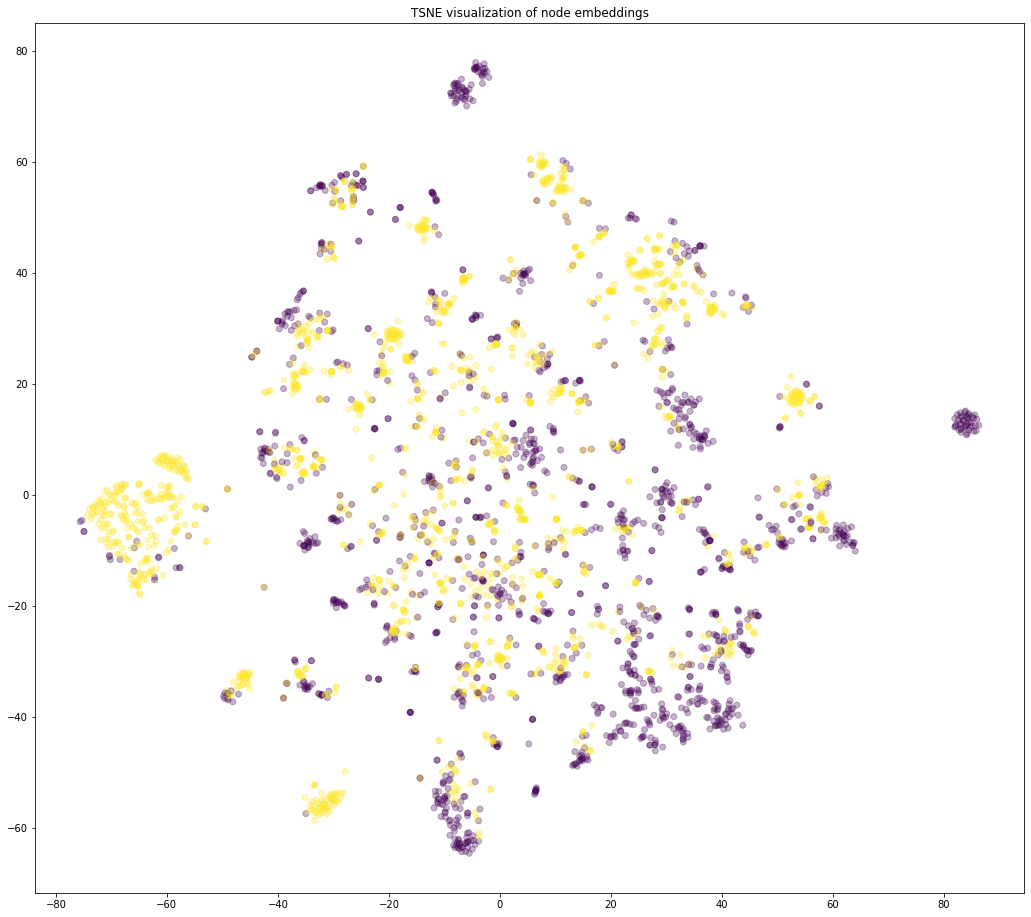

In [178]:
transform = TSNE  # PCA

# plot in 2D
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [22]:
parameters = {
    "p": 1.0,  # Parameter p
    "q": 1.0,  # Parameter q
    "dimensions": 128,  # dimensionality of node2vec embeddings
    "num_walks": 10,  # Number of walks from each node
    "walk_length": 20,  # Walk length
    "window_size": 5,  # Context size for word2vec
    "iter": 50,  # number of SGD iterations (epochs)
    "workers": multiprocessing.cpu_count(),  # number of workers for word2vec
    "weighted": False,  # is graph weighted?
    "directed": False,  # are edges directed?
}

In [62]:
def link_prediction_clf(feature_learner, edge_data, binary_operators=None):
    """
    Performs link prediction given that node features have already been computed. It uses the node features to
    derive edge features using the operators given. Then it trains a Logistic Regression classifier to predict
    links between nodes.

    Args:
        feature_learner: Representation learning object.
        edge_data: (2-tuple) Positive and negative edge data for training the classifier
        binary_operators: Binary operators applied on node features to produce the corresponding edge feature.

    Returns:
        Returns the ROCAUC score achieved by the classifier for each of the specified binary operators.
    """
    scores = (
        []
    )  # the auc values for each binary operator (based on test set performance)
    clf_best = None
    score_best = 0
    op_best = ""

    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    # for each type of binary operator
    for binary_operator in binary_operators:
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        # Split the data and keep X_test, y_test for scoring the model; setting the random_state to
        # the same constant for every iteration gives the same split of data so the comparison is fair.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, test_size=0.25
        )
        # LogisticRegressionCV automatically tunes the parameter C using cross validation and the ROC AUC metric
        clf = Pipeline(
            steps=[
                ("sc", StandardScaler()),
                (
                    "clf",
                    LogisticRegressionCV(
                        Cs=10, cv=10, scoring="roc_auc", verbose=False, max_iter=500
                    ),
                ),
            ]
        )
        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)  # predict on the test set
        if clf.classes_[0] == 1:  # only needs probabilities of positive class
            score_auc = roc_auc_score(y_test, y_pred[:, 0])
        else:
            score_auc = roc_auc_score(y_test, y_pred[:, 1])

        probs = clf.predict_proba(X_test)
        preds = probs[:, 1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)

        # method I: plt
        import matplotlib.pyplot as plt
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        if score_auc >= score_best:
            score_best = score_auc
            clf_best = clf
            op_best = binary_operator

        print(
            "Operator: {} Score (ROC AUC on test set of edge_data): {:.3f}".format(
                binary_operator, score_auc
            )
        )
        scores.append({"op": binary_operator, "score": score_auc})

    return scores, clf_best, op_best


def predict_links(feature_learner, edge_data, clf, binary_operators=None):
    """
    Given a node feature learner and a trained classifier, it computes edge features, uses the classifier to predict
    the given edge data and calculate prediction accuracy.
    :param feature_learner:
    :param edge_data:
    :param clf:
    :param binary_operators:
    :return:
    """

    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    scores = (
        []
    )  # the auc values for each binary operator (based on test set performance)

    # for each type of binary operator
    for binary_operator in binary_operators:
        # Derive edge features from node features using the given binary operator
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        y_pred = clf.predict_proba(X)  # predict
        if clf.classes_[0] == 1:  # only needs probabilities of positive class
            score_auc = roc_auc_score(y, y_pred[:, 0])
        else:
            score_auc = roc_auc_score(y, y_pred[:, 1])

        # print('Correct labels y {}'.format(y))
        # print('Predictions y_pred {}'.format(y_pred[:, 1]))
        print("Prediction score (ROC AUC):", score_auc)
        scores.append({"op": binary_operator, "score": score_auc})

    return scores


def predict(feature_learner, edge_data, clf, binary_operators=None):
    """
    Given a node feature learner and a trained classifier, it computes edge features, uses the classifier to predict
    the given edge data and calculate prediction accuracy.
    :param feature_learner:
    :param edge_data:
    :param clf:
    :param binary_operators:
    :return: a prediction probability for each binary operator in a dictionary where operator is key and prediction is
    the value.
    """

    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    predictions = {}
    # for each type of binary operator
    for binary_operator in binary_operators:
        # Derive edge features from node features using the given binary operator
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        y_pred = clf.predict_proba(X)  # predict

        predictions[binary_operator] = y_pred

    return predictions

In [65]:
def train_heterogeneous_graph(
        g_train,
        g_test,
        output_node_features,  # filename for writing node embeddings
        edge_data_ids_train,
        edge_data_labels_train,  # train edge data
        edge_data_ids_test,
        edge_data_labels_test,  # test edge data
        metapaths,
        parameters,
):
    # Using g_train and edge_data_train train a classifier for edge prediction
    feature_learner_train = Metapath2VecFeatureLearning(
        g_train, embeddings_filename=os.path.expanduser(output_node_features)
    )
    print(
        "Learning {}-dimensional node features (embeddings) from g_train using metapath2vec algorithm with the following parameters:".format(
            parameters["dimensions"]
        )
    )
    print("metapaths: {}".format(metapaths))
    print(
        "\tnum_walks = {}, walk length = {}, context window size = {}".format(
            parameters["num_walks"],
            parameters["walk_length"],
            parameters["window_size"],
        )
    )
    feature_learner_train.fit(
        metapaths=metapaths,
        d=parameters["dimensions"],
        r=parameters["num_walks"],
        l=parameters["walk_length"],
        k=parameters["window_size"],
    )
    # Train the classifier
    binary_operators = ["h"]  #, "avg", "l1", "l2"
    print(
        "Training binary link classifiers (link predictors) using the following binary operators: {}".format(
            binary_operators
        )
    )
    scores_train, clf_edge, binary_operator = link_prediction_clf(
        feature_learner=feature_learner_train,
        edge_data=(edge_data_ids_train, edge_data_labels_train),
        binary_operators=binary_operators,
    )

    # Do representation learning on g_test and use the previously trained classifier on g_train to predict
    # edge_data_test
    feature_learner_test = Metapath2VecFeatureLearning(
        g_test, embeddings_filename=os.path.expanduser(output_node_features)
    )
    print(
        "Learning {}-dimensional node features (embeddings) from g_test using metapath2vec algorithm with the following parameters:".format(
            parameters["dimensions"]
        )
    )
    print("metapaths: {}".format(metapaths))
    print(
        "\tnum_walks = {}, walk length = {}, context window size = {}".format(
            parameters["num_walks"],
            parameters["walk_length"],
            parameters["window_size"],
        )
    )
    feature_learner_test.fit(
        metapaths=metapaths,
        d=parameters["dimensions"],
        r=parameters["num_walks"],
        l=parameters["walk_length"],
        k=parameters["window_size"],
    )

    print(
        "Evaluating best link predictor with {} binary operator on test links in g_test".format(
            binary_operator
        )
    )

    scores = predict_links(
        feature_learner=feature_learner_test,
        edge_data=(edge_data_ids_test, edge_data_labels_test),
        clf=clf_edge,
        binary_operators=[binary_operator],
    )

    print("\n  **** Scores on test set of links (HIN) ****\n")
    for score in scores:
        print(
            "     Operator: {}  Score (ROC AUC): {:.2f}".format(
                score["op"], score["score"]
            )
        )
    print("\n  ****************************")

    return feature_learner_train, feature_learner_test, clf_edge

Graph is not connected
Largest subgraph statistics: 3166 nodes, 18037 edges
Network has 6479 edges of type crc
Network has 6479 edges of type crc
** Sampled 647 positive and 647 negative edges. **
Network has 5832 edges of type crc
Network has 5832 edges of type crc
** Sampled 583 positive and 583 negative edges. **
Learning 128-dimensional node features (embeddings) from g_train using metapath2vec algorithm with the following parameters:
metapaths: [['compound', 'gene', 'compound'], ['compound', 'gene', 'compound', 'compound'], ['compound', 'compound']]
	num_walks = 10, walk length = 20, context window size = 5
(Metapath2VecFeatureLearning) Time for random walks 53 seconds.
(Metapath2VecFeatureLearning) Time to learn embeddings 2 seconds
Total time for fit() was 56
Training binary link classifiers (link predictors) using the following binary operators: ['h']


C:\Users\Zigorat\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Zigorat\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Zigorat\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Zigorat\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Zigorat\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\logistic.py:947: C

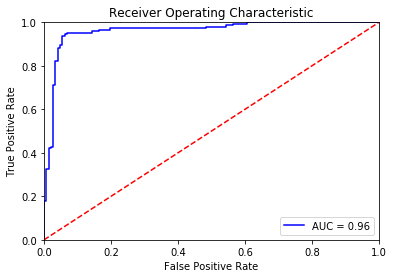

Operator: h Score (ROC AUC on test set of edge_data): 0.961
Learning 128-dimensional node features (embeddings) from g_test using metapath2vec algorithm with the following parameters:
metapaths: [['compound', 'gene', 'compound'], ['compound', 'gene', 'compound', 'compound'], ['compound', 'compound']]
	num_walks = 10, walk length = 20, context window size = 5
(Metapath2VecFeatureLearning) Time for random walks 58 seconds.
(Metapath2VecFeatureLearning) Time to learn embeddings 3 seconds
Total time for fit() was 60
Evaluating best link predictor with h binary operator on test links in g_test
Prediction score (ROC AUC): 0.9699480899837318

  **** Scores on test set of links (HIN) ****

     Operator: h  Score (ROC AUC): 0.97

  ****************************


(<utils.metapath2vec_feature_learning.Metapath2VecFeatureLearning at 0x19c87a10fd0>,
 Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('clf',
                  LogisticRegressionCV(Cs=10, class_weight=None, cv=10,
                                       dual=False, fit_intercept=True,
                                       intercept_scaling=1.0, l1_ratios=None,
                                       max_iter=500, multi_class='warn',
                                       n_jobs=None, penalty='l2',
                                       random_state=None, refit=True,
                                       scoring='roc_auc', solver='lbfgs',
                                       tol=0.0001, verbose=False))],
          verbose=False))

In [66]:
edge_attribute_label = "date"
edge_attribute_threshold = None
attribute_is_datetime = True

p = 0.1
subgraph_size = 0.1
sampling_method = "global"
edge_type = "crc"
sampling_probs = np.array([0.0, 0.25, 0.50, 0.25])
output_node_features = 'hetembed2.emb'

graph_filename = 'hetio.gpickle'
dataset_name = 'het'
# Load the graph from disk
g_nx = read_graph(
    graph_file=graph_filename,
    dataset_name=dataset_name,
    is_directed=parameters["directed"],
    is_weighted=parameters["weighted"],
)

# Check if graph is connected; if not, then select the largest subgraph to continue
if nx.is_connected(g_nx):
    print("Graph is connected")
else:
    print("Graph is not connected")
    # take the largest connected component as the data
    g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
    g_nx = max(g_nx_ccs, key=len)
    print(
        "Largest subgraph statistics: {} nodes, {} edges".format(
            g_nx.number_of_nodes(), g_nx.number_of_edges()
        )
    )

# From the original graph, extract E_test and G_test
edge_splitter_test = EdgeSplitter(g_nx)
(
    g_test,
    edge_data_ids_test,
    edge_data_labels_test,
) = edge_splitter_test.train_test_split(
    p=p,
    edge_label=edge_type,
    edge_attribute_label=edge_attribute_label,
    edge_attribute_threshold=edge_attribute_threshold,
    attribute_is_datetime=attribute_is_datetime,
    method=sampling_method,
    probs=sampling_probs,
)

edge_splitter_train = EdgeSplitter(g_test, g_nx)
(
    g_train,
    edge_data_ids_train,
    edge_data_labels_train,
) = edge_splitter_train.train_test_split(
    p=p,
    edge_label=edge_type,
    edge_attribute_label=edge_attribute_label,
    edge_attribute_threshold=edge_attribute_threshold,
    attribute_is_datetime=attribute_is_datetime,
    method=sampling_method,
    probs=sampling_probs,
)

# this is so that Node2Vec works because it expects Graph not MultiGraph type
g_test = nx.Graph(g_test)
g_train = nx.Graph(g_train)

# prepare the metapaths if given in the command line
metapaths = [
    ["compound", "gene", "compound"],
    ["compound", "gene", "compound", "compound"],
    ["compound", "compound"],
]

train_heterogeneous_graph(
    g_train=StellarGraph(g_train),
    g_test=StellarGraph(g_test),
    output_node_features=output_node_features,
    edge_data_ids_train=edge_data_ids_train,
    edge_data_labels_train=edge_data_labels_train,
    edge_data_ids_test=edge_data_ids_test,
    edge_data_labels_test=edge_data_labels_test,
    metapaths=metapaths,
    parameters=parameters,
)
